In [167]:
#import all relevant packages
import torch, torchvision
import torchvision.transforms as transforms
import numpy as np
from backpack import backpack, extend
from backpack.extensions import DiagHessian, KFAC
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
from torch.nn import functional as F
from mpl_toolkits.axes_grid1 import AxesGrid
plt.rcParams["mpl_toolkits.legacy_colorbar"] = False
import warnings
s=2
np.random.seed(s)
torch.manual_seed(s)
torch.cuda.manual_seed(s)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data wrangling

In [168]:
# data wrangling: load MNIST
MNIST_transform = transforms.Compose([
    transforms.ToTensor(),
])


MNIST_train = torchvision.datasets.MNIST(
        '~/data/mnist',
        train=True,
        download=True,
        transform=MNIST_transform)


MNIST_test = torchvision.datasets.MNIST(
        '~/data/mnist',
        train=False,
        download=False,
        transform=MNIST_transform)


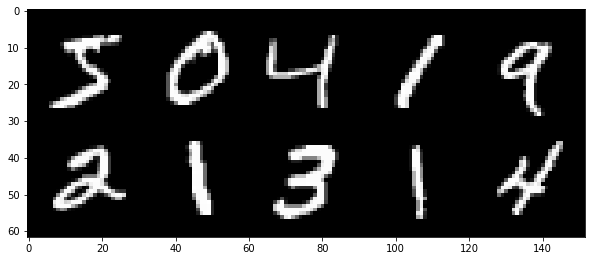

In [169]:
# have a look at the data to verify
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.imshow(npimg)
    plt.show()

images = MNIST_train.data[:10].view(10, 1, 28, 28)
imshow(torchvision.utils.make_grid(images, nrow=5))


In [193]:
print(MNIST_train.data[1])

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,  51, 159, 253, 159,  50,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          48, 238, 252, 252, 252, 237,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [170]:
mnist_train_loader = torch.utils.data.dataloader.DataLoader(
    MNIST_train,
    batch_size=128,
    shuffle=True
)

mnist_test_loader = torch.utils.data.dataloader.DataLoader(
    MNIST_test,
    batch_size=128,
    shuffle=False,
)


# Training routine

In [171]:
#set up the network
def NN(num_classes=10):
    
    features = torch.nn.Sequential(
        torch.nn.Conv2d(1, 32, 5),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2),
        torch.nn.Conv2d(32, 32, 5),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(2,2),
        torch.nn.Flatten(),
        torch.nn.Linear(4 * 4 * 32, num_classes)
    )
    return(features)


In [172]:
#set up the training routine
mnist_model = NN(num_classes=10)
loss_function = torch.nn.CrossEntropyLoss()

mnist_train_optimizer = torch.optim.Adam(mnist_model.parameters(), lr=1e-3, weight_decay=5e-4)
#dont use SGD, it is way worse than Adam here
MNIST_PATH = "MNIST_weights_seed={}.pth".format(s)
#print(MNIST_PATH)

In [173]:
# helper function to get accuracy
def get_accuracy(output, targets):
    """Helper function to print the accuracy"""
    predictions = output.argmax(dim=1, keepdim=True).view_as(targets)
    return predictions.eq(targets).float().mean().item()


In [194]:
# Write the training routine and save the model at FMNIST_PATH

def train(verbose=False, num_iter=5):
    max_len = len(mnist_train_loader)
    for iter in range(num_iter):
        for batch_idx, (x, y) in enumerate(mnist_train_loader):
            print(y)
            output = mnist_model(x)

            accuracy = get_accuracy(output, y)

            loss = loss_function(output, y)
            loss.backward()
            mnist_train_optimizer.step()
            mnist_train_optimizer.zero_grad()

            if verbose:
                if batch_idx % 10 == 0:
                    print(
                        "Iteration {}; {}/{} \t".format(iter, batch_idx, max_len) +
                        "Minibatch Loss %.3f  " % (loss) +
                        "Accuracy %.0f" % (accuracy * 100) + "%"
                    )

    print("saving model at: {}".format(MNIST_PATH))
    torch.save(mnist_model.state_dict(), MNIST_PATH)

In [196]:
#after training it once, comment this out to save time if you rerun the entire script
#train(verbose=True, num_iter=5)


In [176]:
#predict in distribution
MNIST_PATH = "../trained_weights/MNIST/MNIST_weights_seed={}.pth".format(s)

mnist_model = NN(num_classes=10)
print("loading model from: {}".format(MNIST_PATH))
mnist_model.load_state_dict(torch.load(MNIST_PATH))
mnist_model.eval()

#acc = []

#max_len = len(mnist_test_loader)
#for batch_idx, (x, y) in enumerate(mnist_test_loader):
#        output = mnist_model(x)
#        accuracy = get_accuracy(output, y)
#        if batch_idx % 10 == 0:
#            print(
#                "Batch {}/{} \t".format(batch_idx, max_len) + 
#                "Accuracy %.0f" % (accuracy * 100) + "%"
#            )
#        acc.append(accuracy)
#    
#avg_acc = np.mean(acc)
#print('overall test accuracy on MNIST: {:.02f} %'.format(avg_acc * 100))

loading model from: ../trained_weights/MNIST/MNIST_weights_seed=2.pth


Sequential(
  (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=512, out_features=10, bias=True)
)

# Laplace approximation of the weights

## Calculate the KFAC matrices U and V (and B)

In [177]:
#for d in [-6, -4, -2]:
#    bla, blu = list(mnist_model.parameters())[d].kfac
#    print(bla.size(), blu.size())

In [178]:
def get_KFAC_Hessian(model, train_loader, var0, device='cpu', batch_size=128):
    U_s = []
    V_s = []
    B_s = []
    U_invs = []
    V_invs = []
    B_invs = []
    #for params in model.parameters():
    for c in [-2]:
        
        
        #M, N = list(model.parameters())[c].kfac
        #m = M.size()[0]
        #n = N.size()[0]
        W = list(model.parameters())[c]
        
        b = list(model.parameters())[c+1]
        

        
        lossfunc = torch.nn.CrossEntropyLoss()

        tau = 1/var0

        extend(lossfunc, debug=False)
        extend(model, debug=False)
        
        
        
        with backpack(KFAC()):
            #kronecker matrices
            U, V = torch.zeros(m, m, device=device), torch.zeros(n, n, device=device)
            #bias
            B = torch.zeros(m, m, device=device)

            #max_len = int(np.ceil(len(train_loader.dataset)/batch_size))

            for batch_idx, (x, y) in enumerate(train_loader):
                if device == 'cuda':
                    x, y = x.cuda(), y.cuda()


                model.zero_grad()
                lossfunc(model(x), y).backward()

                with torch.no_grad():
                    # Hessian of weight
                    U_, V_ = W.kfac
                    B_ = b.kfac[0]

                    U_ = np.sqrt(batch_size)*U_ + np.sqrt(tau)*torch.eye(m, device=device)
                    V_ = np.sqrt(batch_size)*V_ + np.sqrt(tau)*torch.eye(n, device=device)
                    B_ = batch_size*B_ + tau*torch.eye(m, device=device)

                    rho = min(1-1/(batch_idx+1), 0.95)

                    U = rho*U + (1-rho)*U_
                    V = rho*V + (1-rho)*V_
                    B = rho*B + (1-rho)*B_
                    
                    

            U_inv = torch.inverse(V) 
            V_inv = torch.inverse(U)
            B_inv = torch.inverse(B)
            
            U_invs.append(U_inv)
            V_invs.append(V_inv)
            B_invs.append(B_inv)
            U_s.append(U)
            V_s.append(V)
            B_s.append(B)


    return U_s, V_s, B_s, U_invs, V_invs, B_invs

#KFAC_prec_1 = get_KFAC_Hessian(mnist_model, mnist_train_loader, 1)
#torch.save(KFAC_prec_1, 'KFAC/KFAC_prec_1_seed_{}.pth'.format(s))
#print('saving KFAC_prec_1 ...')
#KFAC_prec_01 = get_KFAC_Hessian(mnist_model, mnist_train_loader, 10)
#torch.save(KFAC_prec_1, 'KFAC/KFAC_prec_01_seed_{}.pth'.format(s))
#print('saving KFAC_prec_01 ...')
#KFAC_prec_001 = get_KFAC_Hessian(mnist_model, mnist_train_loader, 100)
#torch.save(KFAC_prec_1, 'KFAC/KFAC_prec_001_seed_{}.pth'.format(s))
#print('saving KFAC_prec_001 ...')
KFAC_prec_0001 = get_KFAC_Hessian(mnist_model, mnist_train_loader, 1000)
#torch.save(KFAC_prec_0001, 'KFAC/KFAC_prec_0001_seed_{}.pth'.format(s), pickle_module=dill)
print('saving KFAC_prec_0001 ...')
#KFAC_prec_00001 = get_KFAC_Hessian(mnist_model, mnist_train_loader, 10000)
#torch.save(KFAC_prec_00001, 'KFAC/KFAC_prec_00001_seed_{}.pth'.format(s), pickle_module=dill)
print('saving KFAC_prec_00001 ...')

In [179]:
KFAC_prec_1 = torch.load('./KFAC_Matrices/KFAC_prec_1_seed_{}.pth'.format(s), map_location=torch.device('cpu'))
KFAC_prec_01 = torch.load('./KFAC_Matrices/KFAC_prec_01_seed_{}.pth'.format(s), map_location=torch.device('cpu'))
KFAC_prec_001 = torch.load('./KFAC_Matrices/KFAC_prec_001_seed_{}.pth'.format(s), map_location=torch.device('cpu'))
KFAC_prec_0001 = torch.load('./KFAC_Matrices/KFAC_prec_0001_seed_{}.pth'.format(s), map_location=torch.device('cpu'))
KFAC_prec_00001 = torch.load('./KFAC_Matrices/KFAC_prec_00001_seed_{}.pth'.format(s), map_location=torch.device('cpu'))

torch.Size([10, 10])
0.0031622767


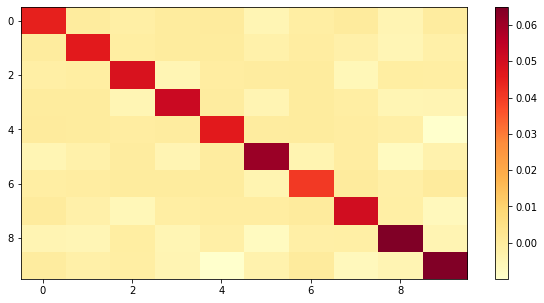

torch.Size([512, 512])
17.658728


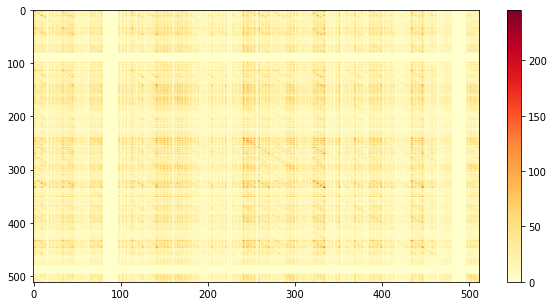

torch.Size([10, 10])
9.999901e-05


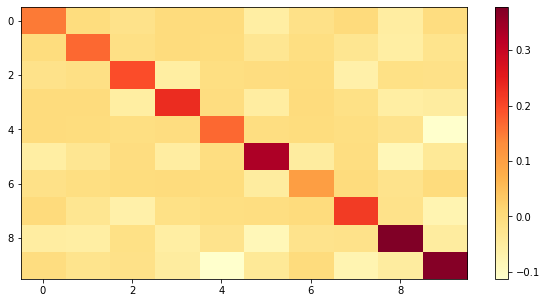

torch.Size([512, 512])
0.00398975


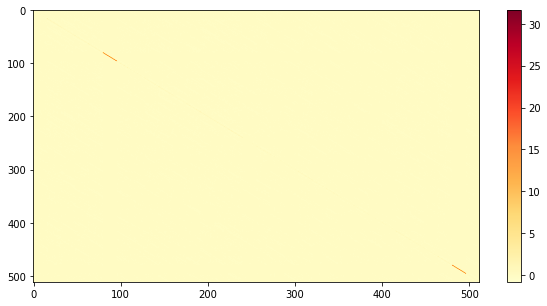

torch.Size([10, 10])
3.1622787


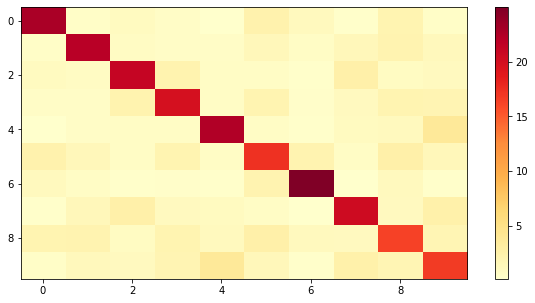

torch.Size([10, 10])
100.0002


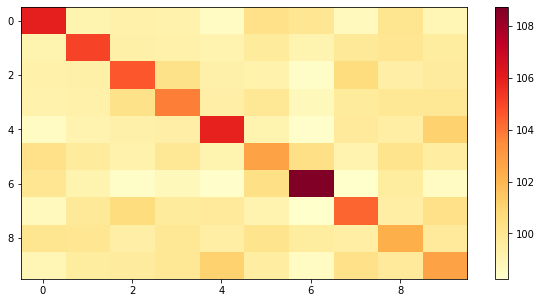

In [207]:
plt.rcParams["figure.figsize"] = (10,5)
lyr = 2
cmap = 'YlOrRd'
print(KFAC_prec_0001[0][lyr].size())
print(np.mean(KFAC_prec_0001[0][lyr].detach().numpy()))
plt.imshow(KFAC_prec_0001[0][lyr], cmap=cmap, aspect='auto')
plt.colorbar()
plt.show()
print(KFAC_prec_0001[1][lyr].size())
print(np.mean(KFAC_prec_0001[1][lyr].detach().numpy()))
plt.imshow(KFAC_prec_0001[1][lyr], cmap=cmap, aspect='auto')
plt.colorbar()
plt.show()
print(KFAC_prec_0001[2][lyr].size())
print(np.mean(KFAC_prec_0001[2][lyr].detach().numpy()))
plt.imshow(KFAC_prec_0001[2][lyr], cmap=cmap, aspect='auto')
plt.colorbar()
plt.show()
print(KFAC_prec_0001[3][lyr].size())
print(np.mean(KFAC_prec_0001[3][lyr].detach().numpy()))
plt.imshow(KFAC_prec_0001[3][lyr], cmap=cmap, aspect='auto')
plt.colorbar()
plt.show()
print(KFAC_prec_0001[4][lyr].size())
print(np.mean(KFAC_prec_0001[4][lyr].detach().numpy()))
plt.imshow(KFAC_prec_0001[4][lyr], cmap=cmap, aspect='auto')
plt.colorbar()
plt.show()
print(KFAC_prec_0001[5][lyr].size())
print(np.mean(KFAC_prec_0001[5][lyr].detach().numpy()))
plt.imshow(KFAC_prec_0001[5][lyr], cmap=cmap, aspect='auto')
plt.colorbar()
plt.show()

In [181]:
for i in [0, 1, 2]:
    print('{}. layer'.format(i))
    print(np.mean(KFAC_prec_0001[0][i].detach().numpy()))
    print(np.mean(KFAC_prec_0001[1][i].detach().numpy()))
    print(np.mean(KFAC_prec_0001[2][i].detach().numpy()))
    print(np.mean(KFAC_prec_0001[3][i].detach().numpy()))
    print(np.mean(KFAC_prec_0001[4][i].detach().numpy()))
    print(np.mean(KFAC_prec_0001[5][i].detach().numpy()))
    print()

0. layer
0.0031105275
543.62494
0.024042511
3.4084246e-06
0.50763
0.17248407

1. layer
0.0011882538
71.68702
0.00229447
1.7459924e-05
0.8391861
2.6522617

2. layer
0.0031622767
17.658728
9.999901e-05
0.00398975
3.1622787
100.0002



# First conv layer

In [182]:
print('U diag: ')
print(KFAC_prec_0001[0][0].diagonal())
print('V diag: ')
print(KFAC_prec_0001[1][0].diagonal())
print('B diag: ')
print(KFAC_prec_0001[2][0].diagonal())
print('U_inv diag: ')
print(KFAC_prec_0001[3][0].diagonal())
print('V_inv diag: ')
print(KFAC_prec_0001[4][0].diagonal())
print('B_inv diag: ')
print(KFAC_prec_0001[5][0].diagonal())

U diag: 
tensor([0.0423, 0.1877, 0.0446, 0.2398, 0.0669, 0.1555, 0.4190, 0.1076, 0.2566,
        0.0916, 0.1394, 0.2449, 0.2167, 0.1245, 0.0704, 0.0482, 0.2164, 0.1551,
        0.1392, 0.3190, 0.1455, 0.0540, 0.1023, 0.0460, 0.0586, 0.0482, 0.0803,
        0.0897, 0.0706, 0.3627, 0.1002, 0.0548])
V diag: 
tensor([975.3687, 978.2463, 978.8892, 978.9019, 978.3115, 989.5604, 992.4396,
        993.0826, 993.0948, 992.4970, 994.4515, 997.3311, 997.9740, 997.9863,
        997.3880, 995.0368, 997.9163, 998.5593, 998.5715, 997.9734, 991.2401,
        994.1155, 994.7584, 994.7706, 994.1727])
B diag: 
tensor([0.1219, 1.7666, 0.1476, 2.3563, 0.4001, 1.4027, 4.3835, 0.8611, 2.5466,
        0.6796, 1.2208, 2.4134, 2.0948, 1.0517, 0.4397, 0.1881, 2.0915, 1.3984,
        1.2182, 3.2522, 1.2889, 0.2538, 0.8007, 0.1637, 0.3061, 0.1886, 0.5517,
        0.6581, 0.4414, 3.7465, 0.7774, 0.2633])
U_inv diag: 
tensor([0.0074, 0.0134, 0.0143, 0.0138, 0.0083, 0.0131, 0.0180, 0.0184, 0.0179,
        0.0133, 0.0

## V_inv

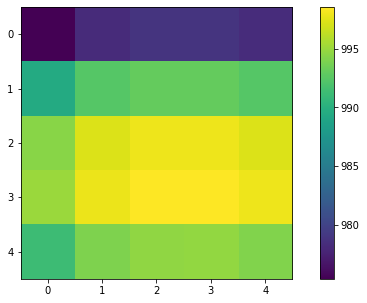

In [202]:
im = plt.imshow(np.reshape(KFAC_prec_0001[1][0].diagonal(), (5, -1)))
plt.colorbar()
plt.show()

## V

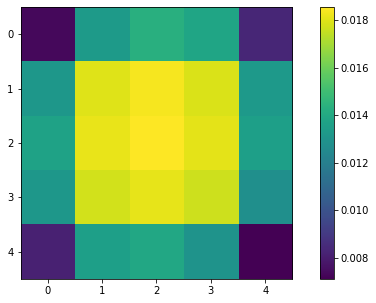

In [203]:
im = plt.imshow(np.reshape(KFAC_prec_0001[3][0].diagonal(), (5, -1)))
plt.colorbar()
plt.show()

# Second conv layer

## V_inv:

0.47614944


/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The set_cmap function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_cmap instead.
/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Use the colorbar set_ticks() method instead.


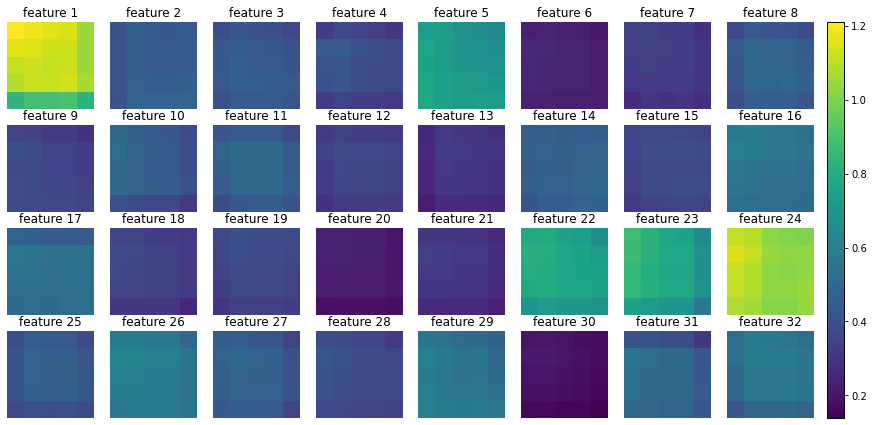

In [184]:
kfac_diag = KFAC_prec_0001[3][1].diagonal()
print(np.mean(kfac_diag.detach().numpy()))
fig = plt.figure(figsize=(15, 10))

grid = AxesGrid(fig, 111, nrows_ncols=(4, 8), axes_pad=0.22, cbar_mode='single', 
                cbar_location='right', cbar_pad=0.18)

#mnist_number = 490
linear_layer_index = 1 #linear layer has index 4
linear_layer_diag = KFAC_prec_0001[3][linear_layer_index].diagonal()

#reshape the flattened array to 32* (4x4)
layer_split = np.array_split(np.array(linear_layer_diag), 32)
for i in range(len(layer_split)-1):
    layer_split[i] = np.reshape(layer_split[i], (5, -1))

min_val = min(list(torch.flatten(linear_layer_diag).detach().numpy()))
max_val = max(list(torch.flatten(linear_layer_diag).detach().numpy()))

for i, ax in enumerate(grid):
    ax.set_axis_off()
    layer_split[i] = np.reshape(layer_split[i], (5, -1))
    im = ax.imshow(layer_split[i], vmin=min_val, vmax=max_val)
    ax.set_title('feature '+str(i+1))
    
cbar = ax.cax.colorbar(im)
cbar = grid.cbar_axes[0].colorbar(im)

cbar.ax.set_yticks(np.arange(min_val, max_val, 0.10))
plt.show()

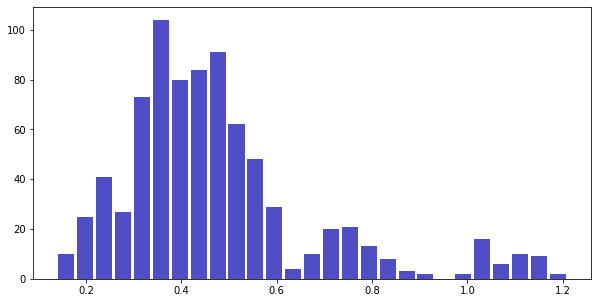

In [185]:
plt.hist(kfac_diag, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.show()

## V:

176.71994


/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The set_cmap function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_cmap instead.
/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Use the colorbar set_ticks() method instead.


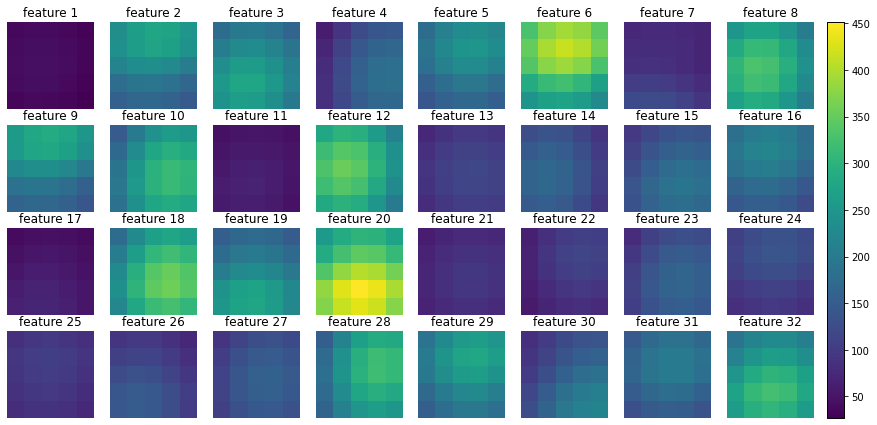

In [186]:
kfac_diag = KFAC_prec_0001[1][1].diagonal()
print(np.mean(kfac_diag.detach().numpy()))
fig = plt.figure(figsize=(15, 10))

grid = AxesGrid(fig, 111, nrows_ncols=(4, 8), axes_pad=0.22, cbar_mode='single', 
                cbar_location='right', cbar_pad=0.18)

#mnist_number = 490
linear_layer_index = 1 #linear layer has index 4
linear_layer_diag = KFAC_prec_0001[1][linear_layer_index].diagonal()

#reshape the flattened array to 32* (4x4)
layer_split = np.array_split(np.array(linear_layer_diag), 32)
for i in range(len(layer_split)-1):
    layer_split[i] = np.reshape(layer_split[i], (5, -1))

min_val = min(list(torch.flatten(linear_layer_diag).detach().numpy()))
max_val = max(list(torch.flatten(linear_layer_diag).detach().numpy()))

for i, ax in enumerate(grid):
    ax.set_axis_off()
    layer_split[i] = np.reshape(layer_split[i], (5, -1))
    im = ax.imshow(layer_split[i], vmin=min_val, vmax=max_val)
    ax.set_title('feature '+str(i+1))
    
cbar = ax.cax.colorbar(im)
cbar = grid.cbar_axes[0].colorbar(im)

cbar.ax.set_yticks(np.arange(min_val, max_val, 50))
plt.show()

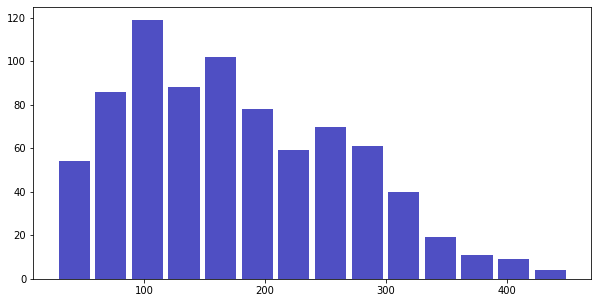

In [187]:
plt.hist(kfac_diag, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.show()

# Visualization of linear layer (diagonal of KFAC)

## V_inv:

2.858805


/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The set_cmap function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_cmap instead.
/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Use the colorbar set_ticks() method instead.


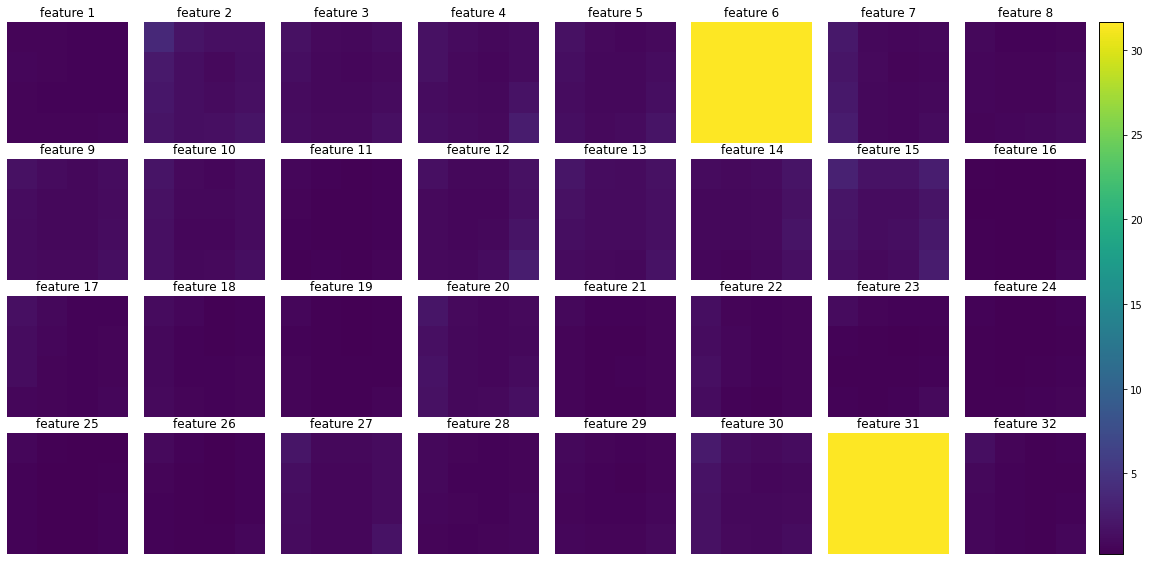

In [205]:
kfac_diag = KFAC_prec_0001[3][2].diagonal()
print(np.mean(kfac_diag.detach().numpy()))
fig = plt.figure(figsize=(20, 15))

grid = AxesGrid(fig, 111, nrows_ncols=(4, 8), axes_pad=0.22, cbar_mode='single', 
                cbar_location='right', cbar_pad=0.18)

#mnist_number = 490
linear_layer_index = 2 #linear layer has index 4
linear_layer_diag = KFAC_prec_0001[3][linear_layer_index].diagonal()

#reshape the flattened array to 32* (4x4)
layer_split = np.array_split(np.array(linear_layer_diag), 32)
for i in range(len(layer_split)-1):
    layer_split[i] = np.reshape(layer_split[i], (4, -1))

min_val = min(list(torch.flatten(linear_layer_diag).detach().numpy()))
max_val = max(list(torch.flatten(linear_layer_diag).detach().numpy()))

for i, ax in enumerate(grid):
    ax.set_axis_off()
    layer_split[i] = np.reshape(layer_split[i], (4, -1))
    im = ax.imshow(layer_split[i], vmin=min_val, vmax=max_val)
    ax.set_title('feature '+str(i+1))
    
cbar = ax.cax.colorbar(im)
cbar = grid.cbar_axes[0].colorbar(im)

cbar.ax.set_yticks(np.arange(min_val, max_val, 10))
plt.show()

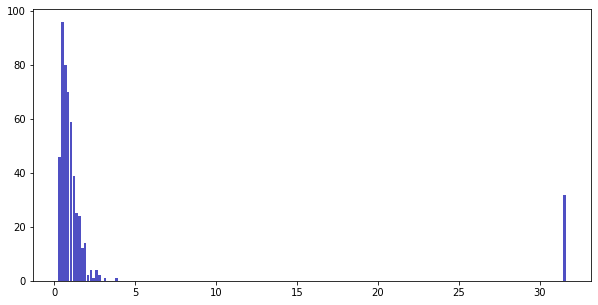

In [189]:
plt.hist(kfac_diag, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.show()

## V:

50.221962


/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The set_cmap function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_cmap instead.
/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The set_clim function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use ScalarMappable.set_clim instead.
/Users/moreez/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: UserWarning: Use the colorbar set_ticks() method instead.


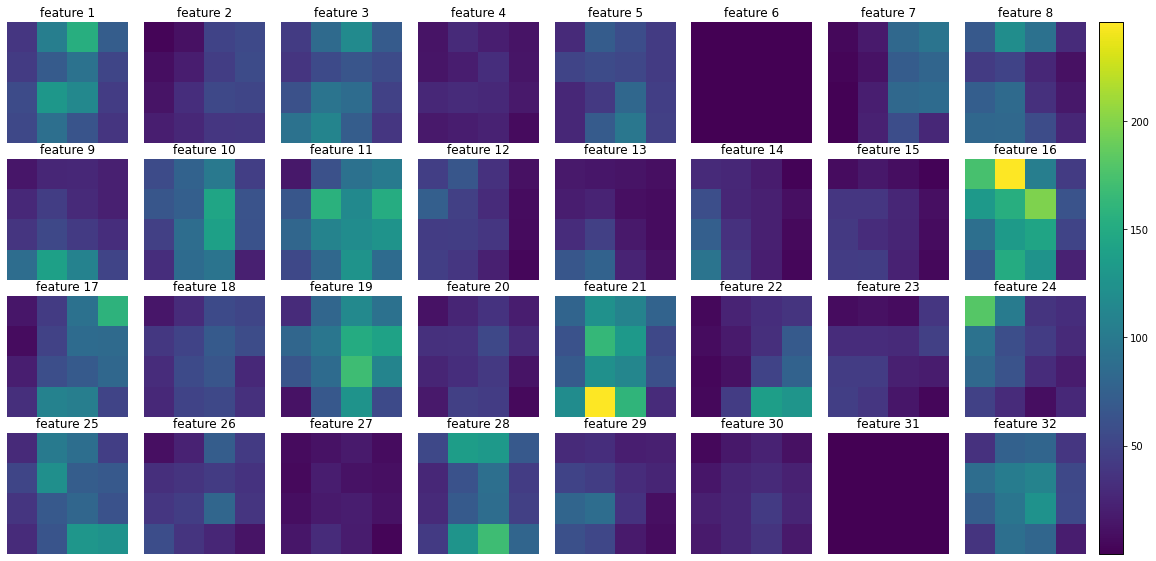

In [190]:
kfac_diag = KFAC_prec_0001[1][2].diagonal()
print(np.mean(kfac_diag.detach().numpy()))
fig = plt.figure(figsize=(20, 15))

grid = AxesGrid(fig, 111, nrows_ncols=(4, 8), axes_pad=0.22, cbar_mode='single', 
                cbar_location='right', cbar_pad=0.18)

#mnist_number = 490
linear_layer_index = 2 #linear layer has index 4
linear_layer_diag = KFAC_prec_0001[1][linear_layer_index].diagonal()

#reshape the flattened array to 32* (4x4)
layer_split = np.array_split(np.array(linear_layer_diag), 32)
for i in range(len(layer_split)-1):
    layer_split[i] = np.reshape(layer_split[i], (4, -1))

min_val = min(list(torch.flatten(linear_layer_diag).detach().numpy()))
max_val = max(list(torch.flatten(linear_layer_diag).detach().numpy()))

for i, ax in enumerate(grid):
    ax.set_axis_off()
    layer_split[i] = np.reshape(layer_split[i], (4, -1))
    im = ax.imshow(layer_split[i], vmin=min_val, vmax=max_val)
    ax.set_title('feature '+str(i+1))
    
cbar = ax.cax.colorbar(im)
cbar = grid.cbar_axes[0].colorbar(im)

cbar.ax.set_yticks(np.arange(min_val, max_val, 10))
plt.show()

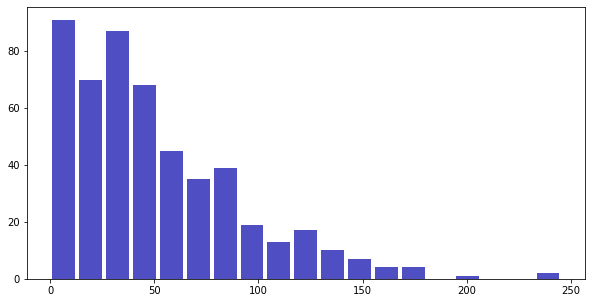

In [191]:
plt.hist(kfac_diag, bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)
plt.show()